<div class="alert alert-success">
    <h1 align="center">Lesson 01: Image Classification (Cats vs Dogs)</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Image Classification

<img src='imgs/Image_tasks.jpg' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
use_gpu

False

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [3]:
# DATA_DIR = "D:/datasets/catsvsdogs/"
# DATA_DIR = "D:/datasets/catsvsdogs/dev/"
DATA_DIR = 'DATA/datasets/catsvsdogs/dev/'
sz = 224
batch_size = 16

In [4]:
os.listdir(DATA_DIR)

['train', 'valid']

In [5]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [6]:
os.listdir(trn_dir)

['cat', 'dog']

In [7]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['DATA/datasets/catsvsdogs/dev/train\\cat\\0.jpg',
 'DATA/datasets/catsvsdogs/dev/train\\cat\\1.jpg',
 'DATA/datasets/catsvsdogs/dev/train\\cat\\10.jpg',
 'DATA/datasets/catsvsdogs/dev/train\\cat\\100.jpg',
 'DATA/datasets/catsvsdogs/dev/train\\cat\\101.jpg']

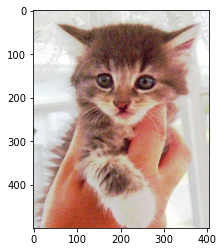

In [8]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [9]:
train_ds = datasets.ImageFolder(trn_dir)

In [10]:
train_ds.classes

['cat', 'dog']

In [11]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [12]:
train_ds.root

'DATA/datasets/catsvsdogs/dev/train'

In [13]:
train_ds.imgs

[('DATA/datasets/catsvsdogs/dev/train\\cat\\0.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\1.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\10.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\100.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\101.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\102.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\103.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\104.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\105.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\106.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\107.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\108.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\109.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\11.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\110.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\111.jpg', 0),
 ('DATA/datasets/catsvsdogs/dev/train\\cat\\112.jpg', 0),
 ('DATA/datasets/cat

In [14]:
# list(zip(*train_ds.imgs))

In [15]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [16]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [17]:
len(train_ds), len(valid_ds)

(2000, 100)

#### Dataloaders

In [18]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

C:\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


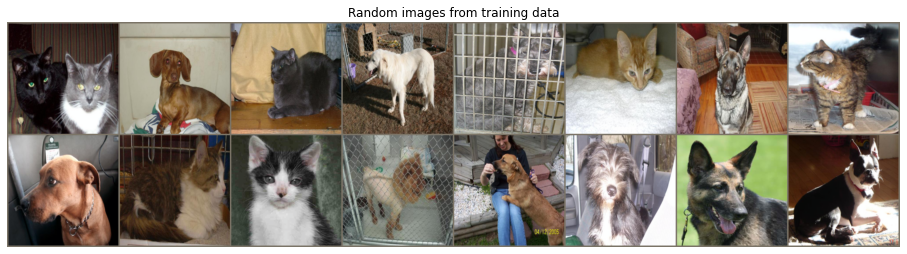

In [19]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [20]:
# ??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [21]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [22]:
model = SimpleCNN()

# transfer model to GPU
if use_gpu:
    model = model.cuda()

In [23]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## Loss function and optimizer

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [25]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        # losses += [loss.data[0]]
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

Epoch [ 1/10], Step [ 50/125], Loss: 4.6994
Epoch [ 1/10], Step [100/125], Loss: 0.6796
Epoch [ 2/10], Step [ 50/125], Loss: 0.6699
Epoch [ 2/10], Step [100/125], Loss: 0.6401
Epoch [ 3/10], Step [ 50/125], Loss: 0.7247
Epoch [ 3/10], Step [100/125], Loss: 0.6202
Epoch [ 4/10], Step [ 50/125], Loss: 0.5604
Epoch [ 4/10], Step [100/125], Loss: 0.6814
Epoch [ 5/10], Step [ 50/125], Loss: 0.8771
Epoch [ 5/10], Step [100/125], Loss: 0.6088
Epoch [ 6/10], Step [ 50/125], Loss: 0.6199
Epoch [ 6/10], Step [100/125], Loss: 0.3353
Epoch [ 7/10], Step [ 50/125], Loss: 0.5152
Epoch [ 7/10], Step [100/125], Loss: 0.5124
Epoch [ 8/10], Step [ 50/125], Loss: 0.4955
Epoch [ 8/10], Step [100/125], Loss: 0.6384
Epoch [ 9/10], Step [ 50/125], Loss: 0.3582
Epoch [ 9/10], Step [100/125], Loss: 0.3127
Epoch [10/10], Step [ 50/125], Loss: 0.5009
Epoch [10/10], Step [100/125], Loss: 0.4409


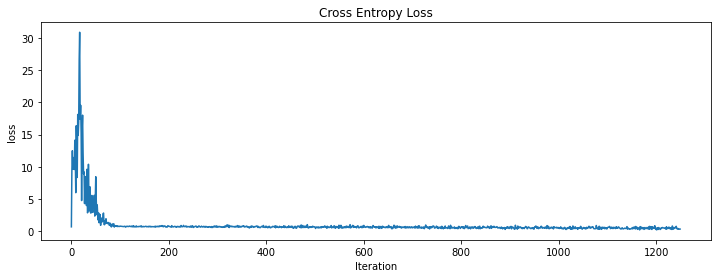

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

### Analyze results

#### Accuracy on validation data

In [27]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [28]:
evaluate_model(model, valid_dl)

C:\Users\Amin\ML\Deep_Learning_in_Python_2018-master\Week01\utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 56.00


In [29]:
evaluate_model(model, train_dl)

accuracy: 87.50


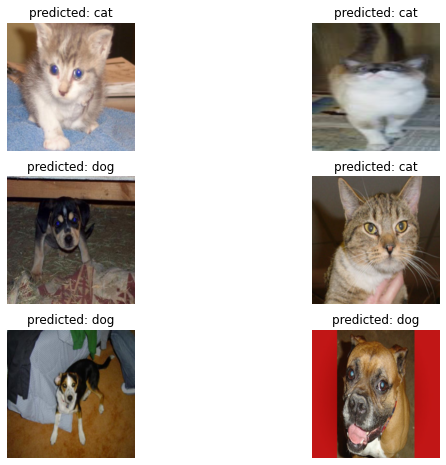

In [30]:
visualize_model(model, train_dl)

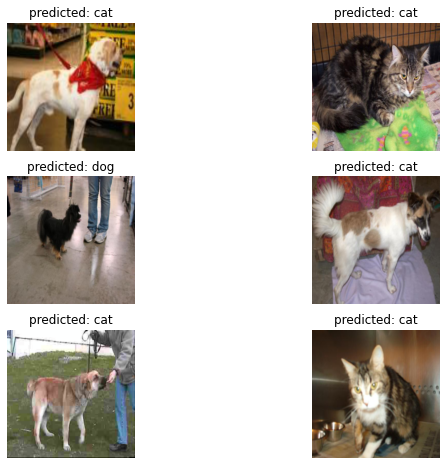

In [31]:
visualize_model(model, valid_dl)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:32<00:00,  4.63s/it]


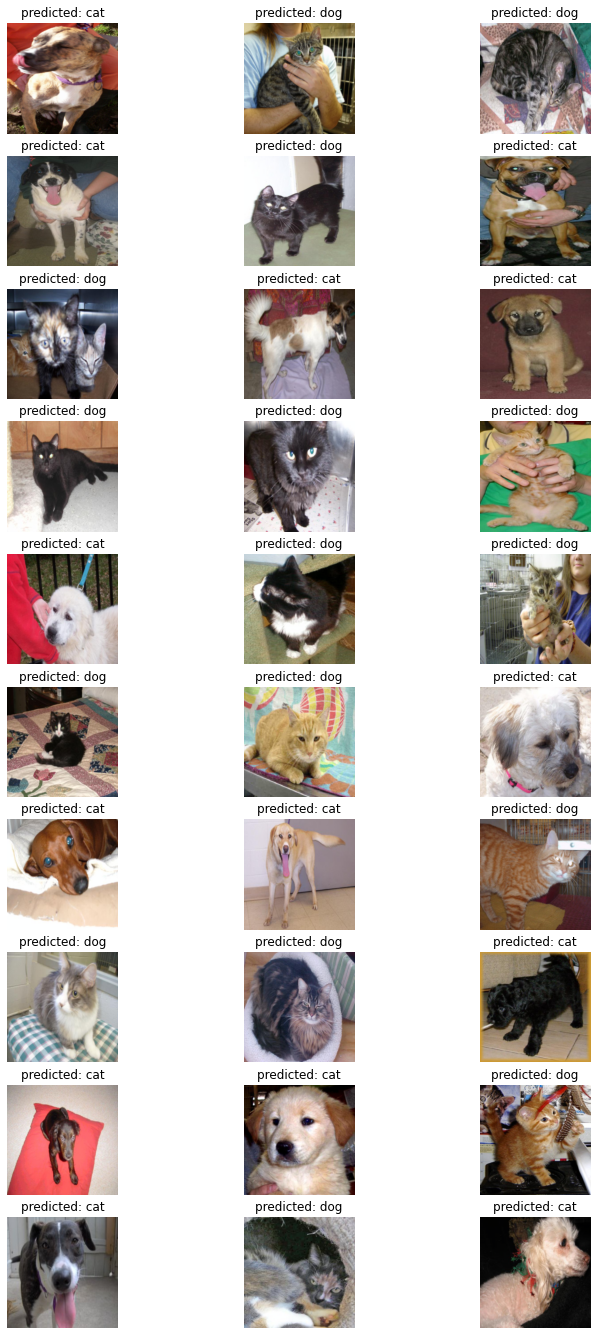

33 images out of 100 were misclassified.


In [32]:
plot_errors(model, valid_dl)

#### Confusion matrix

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:30<00:00,  4.37s/it]


[[0.62 0.38]
 [0.5  0.5 ]]


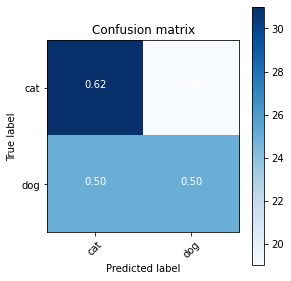

In [33]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

In [ ]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

In [ ]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
# create model
model = SimpleCNN()
if use_gpu:
    model = model.cuda()
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=5)

## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [ ]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=2)

In [ ]:
evaluate_model(model, valid_dl)

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

## PROGRAMMING ASSIGNMENT 1

<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    <ul>
        <li><strong>Objective:</strong> getting a rank among top 50% in LB.</li>
        <li><strong>Ideas:</strong> different augmentations, different architectures, etc.</li>
        <li><strong>Important:</strong> share your ideas and progress on Piazz.</li>
    </ul>
</div>